In [1]:
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import h5py
import pickle
import pandas
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [3]:
# split-QCDvsTop-data for VAE training

### Mila cluster
input_filename="/data/sxg3847/v0-samples/v0/train.h5"

store=pandas.HDFStore(input_filename) # pytable interface in pandas

data=store.select('table', stop=100000)
qcd_all=data[data["is_signal_new"]==0] # data selection [0: qcd; 1: top]
qcd_all=qcd_all.values # transform into numpy arrays
qcd_all=qcd_all[:,0:400]
    
for i in range(1,12): # range(1, 4) for validation and test set
    data=store.select("table", start=i*100000, stop=(i+1)*100000) # pandas dataframe
    qcd=data[data["is_signal_new"]==0] # data selection [0: qcd; 1: top]
    qcd=qcd.values # transform into numpy arrays
    qcd=qcd[:,0:400]
    qcd_all=np.append(qcd_all, qcd, axis=0)

data_out=h5py.File('AE_train_qcd.h5', 'w')
dset=data_out.create_dataset('table', data=qcd_all)
data_out.close()

In [ ]:
### Preprocessing 
from preprocessing import preprocessing 

In [ ]:
f=h5py.File('AE_train_qcd.h5','r')
data=f['table']
data_preprocessed=[]

In [ ]:
for i in range(len(data)):
    if i%10000==0:
        print i
    data_preprocessed.append(preprocessing(data[i]))

In [ ]:
data_preprocessed=np.vstack(data_preprocessed)
data_out=h5py.File('AE_train_qcd_preprocessed.h5', 'w')
dset=data_out.create_dataset('table', data=data_preprocessed)
data_out.close()
data_out=h5py.File('AE_train_qcd_preprocessed.h5', 'w')
dset=data_out.create_dataset('table', data=data_preprocessed)
data_out.close()
f.close()

In [5]:
### Loading Data

from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler

In [6]:
LEN_INPUT=80

In [7]:
def load_data(filename, len_input=80):
    # set input length
    #len_input=80

    # load hdf5 dataset: data/AE_training_qcd.h5
    f_train=h5py.File(filename,'r')
    #f_validation=h5py.File('data/AE_validation_qcd.h5', 'r')

    x_train=f_train['table']
    #x_validation=f_validation['table']

    x_train.shape
    #x_validation.shape

    x_train=x_train[:,:len_input]
    #x_validation=x_validation[:,:200]

    scaler=RobustScaler().fit(x_train)

    x_train=scaler.transform(x_train)
    #x_validation=tf.transform(x_validation)
    f_train.close()
    return x_train

In [8]:
x_train=load_data('AE_train_qcd_preprocessed.h5', 80)

## Model: FCN

In [9]:
### Model: FCN

from keras.utils import plot_model
from keras.utils import multi_gpu_model

In [10]:
input_dim=x_train.shape[1]

input_vec = Input(shape =(input_dim,))

encoded = Dense(256, activation='relu')(input_vec)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(6, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder=Model(input_vec, decoded)

#Data parallelism working with multi GPUs within keras
#parallel_autoencoder = multi_gpu_model(autoencoder, gpus=2)

autoencoder.compile(optimizer="adam",
                    #optimizer="rmsprop",
                    loss="kullback_leibler_divergence") # feels like cheating... but somehow it works... still in the process of writing a more appropriate loss...
                    #loss="mean_squared_error")
                    #loss="cosine")

In [11]:
# Training
from keras.callbacks import EarlyStopping

#cp = ModelCheckpoint(filepath="autoencoder.h5",
#                               save_best_only=True,
#                               verbose=0)

#tb = TensorBoard(log_dir='./logs',
#                histogram_freq=0,
#                write_graph=True,
#                write_images=True)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8)

history=autoencoder.fit(x_train, x_train, epochs=100,
               batch_size=128,
               shuffle='batch',
               validation_split=0.2,
               #validation_data=(x_validation, x_validation),
               callbacks=[early_stopping])

Train on 480058 samples, validate on 120015 samples
Epoch 1/100
480058/480058 [==============================] - 20s 43us/step - loss: 78.7544 - val_loss: 78.2550
Epoch 2/100
480058/480058 [==============================] - 21s 43us/step - loss: 78.0887 - val_loss: 77.9768
Epoch 3/100
480058/480058 [==============================] - 20s 43us/step - loss: 77.8718 - val_loss: 77.8137
Epoch 4/100
480058/480058 [==============================] - 20s 42us/step - loss: 77.7292 - val_loss: 77.6595
Epoch 5/100
480058/480058 [==============================] - 20s 42us/step - loss: 77.6277 - val_loss: 77.6065
Epoch 6/100
480058/480058 [==============================] - 20s 42us/step - loss: 77.5660 - val_loss: 77.5136
Epoch 7/100
480058/480058 [==============================] - 20s 42us/step - loss: 77.5180 - val_loss: 77.4839
Epoch 8/100
480058/480058 [==============================] - 20s 42us/step - loss: 77.4766 - val_loss: 77.4582
Epoch 9/100
480058/480058 [==============================] -

DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/sxg3847/env/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans (u'/home/sxg3847/env/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral (u'/home/sxg3847/env/local/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager] findfont: Matching :family=STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXSizeOneSym (u'/home/sxg

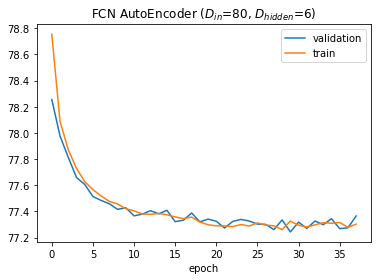

In [12]:
plt.plot(history.history['val_loss'], label='validation')
plt.plot(history.history['loss'], label='train')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [13]:
autoencoder.save('AE-FCN-model-d80.h5')
#f_train.close()
#f_validation.close()

### Model Evaluation

In [14]:
### Model Evaluation

from keras.models import load_model
from sklearn.metrics import mutual_info_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import StandardScaler, RobustScaler
#from preprocessing import preprocessing

from keras.losses import kullback_leibler_divergence, mean_squared_error, cosine

In [15]:
# Load training data and obtrain the scaler fit
f_train=h5py.File('AE_train_qcd_preprocessed.h5','r')
x_train=f_train['table']
scaler=RobustScaler().fit(x_train[:10000, :LEN_INPUT]) #len_input
f_train.close()

In [16]:
# Load preprocessed test data

f_test_0=h5py.File('AE_test_qcd_preprocessed.h5','r')
f_test_1=h5py.File('AE_test_top_preprocessed.h5','r')
x_test_0=f_test_0['table']
x_test_1=f_test_1['table']

x_test=np.concatenate((x_test_0, x_test_1), axis=0)
y_test=np.concatenate((np.zeros(len(x_test_0)), np.ones(len(x_test_1))), axis=0)

rng = check_random_state(1)
indices = rng.permutation(len(x_test))

x_test_mix = [x_test[j] for j in indices[:100000]]
y_test_mix = [y_test[j] for j in indices[:100000]]
f_test_0.close()
f_test_1.close()

In [17]:
x_test_mix=np.array(x_test_mix)
y_test_mix=np.array(y_test_mix)

In [18]:
# Load the model
autoencoder=load_model('AE-FCN-model-d80.h5')

In [19]:
x_test_mix=scaler.transform(x_test_mix[:,:LEN_INPUT])

In [20]:
predict_jets=autoencoder.predict(x_test_mix)

In [21]:
predict_loss_mse= np.mean(np.power(x_test_mix - predict_jets, 2), axis=1)
#def cos_distance(y_true, y_pred):
#    def l2_normalize(x, axis):
#        norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
#        return K.sign(x) * K.maximum(K.abs(x), K.epsilon()) / K.maximum(norm, K.epsilon())
#    y_true = l2_normalize(y_true, axis=-1)
#    y_pred = l2_normalize(y_pred, axis=-1)
#    return K.mean(y_true * y_pred, axis=-1)
#predict_loss_cosine=cosine(x_test_mix, np.float64(predict_jets))

In [22]:
#a = tf.convert_to_tensor(x_test_mix, np.float64)
#b = tf.convert_to_tensor(predict_jets, np.float64)
#predict_loss_kl=kullback_leibler_divergence(a,b)
#predict_loss_kl=K.eval(predict_loss_kl)

In [23]:
predict_loss=predict_loss_mse

In [24]:
# Add scaling for predict_loss, not mandatory
tf_loss=StandardScaler().fit(predict_loss.reshape(-1,1))
predict_loss=tf_loss.transform(predict_loss.reshape(-1,1))

(array([2.0002e+04, 3.3746e+04, 1.4265e+04, 7.2800e+03, 5.1140e+03,
        3.6270e+03, 2.8370e+03, 2.2290e+03, 1.7970e+03, 1.4760e+03,
        1.3330e+03, 1.0090e+03, 9.7900e+02, 7.7200e+02, 6.9700e+02,
        5.2300e+02, 5.0000e+02, 3.7600e+02, 3.0300e+02, 2.5700e+02,
        2.0900e+02, 1.5300e+02, 1.2400e+02, 1.0100e+02, 6.9000e+01,
        4.8000e+01, 5.3000e+01, 3.7000e+01, 2.5000e+01, 1.7000e+01,
        1.3000e+01, 1.0000e+01, 7.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-0.85732546, -0.6069239 , -0.35652235, -0.1061208 ,  0.14428075,
         0.3946823 ,  0.64508385,  0.8954854 ,  1.14588695,  1.3962885 ,
         1.64669005,  1.8970916 ,  2.14749316,  2.39789471,  2.64829626,
         2.89869781,  3.14909936,  3.39950091,  3.64990246,  3.90030401,
         4.15070556,  4.40

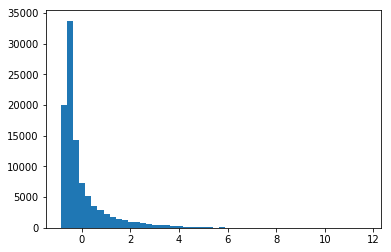

In [25]:
plt.hist(predict_loss, bins=50)

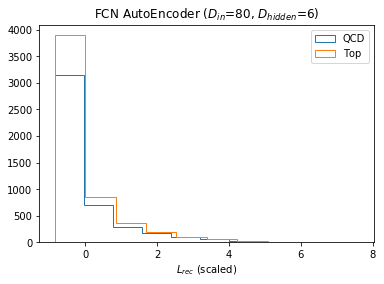

In [26]:
l_rec_0=[]
l_rec_1=[]

for i in range(10000):
    if y_test_mix[i]==0:
        l_rec_0.append(predict_loss[i])
    else:
        l_rec_1.append(predict_loss[i])

l_rec_0=np.array(l_rec_0)
l_rec_1=np.array(l_rec_1)
plt.hist(l_rec_0, histtype="step", label='QCD')
plt.hist(l_rec_1, histtype='step', label='Top')
plt.legend(loc='best')
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.xlabel('$L_{rec}$ (scaled)')
plt.show()

/home/sxg3847/env/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


('roc_auc =', 0.4976113050072822)


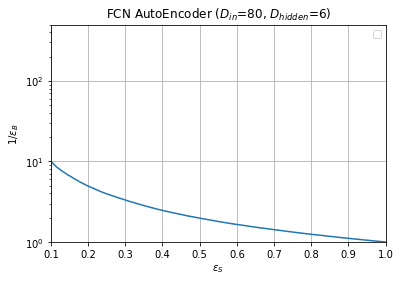

In [27]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thrs = roc_curve(y_test_mix, predict_loss)
print("roc_auc =", roc_auc_score(y_test_mix, predict_loss))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.title('FCN AutoEncoder ($D_{in}$=80, $D_{hidden}$=6)')
plt.grid()
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()

## Model: LSTM

In [28]:
from keras.layers import Input, LSTM, RepeatVector #, CuDNNLSTM

In [29]:
x_train=load_data('AE_train_qcd_preprocessed.h5', LEN_INPUT)
#x_train=normalize(x_train, norm='l2',axis=0)# 1: normalize each feature; 1: normalize each sample
x_train=np.reshape(x_train,(len(x_train), -1, 4))
#x_validation=np.reshape(x_validation, (len(x_validation), -1, 4))

In [30]:
input_dim=4
timesteps=int(LEN_INPUT/4)
latent_dim=10

inputs = Input(shape=(None, input_dim))
encoded = LSTM(latent_dim)(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)  # for CPU users
#decoded = CuDNNLSTM(input_dim, return_sequences=True)(decoded) # for GPU users

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [31]:
sequence_autoencoder.compile(optimizer="adam",
                    # change the loss to measure difference
                    # between distributions (D_{KL})
                    #loss="kullback_leibler_divergence")
                    loss="mean_squared_error")

In [32]:
from keras.callbacks import TensorBoard, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10)

history=sequence_autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping] 
                                )

#validation_data=(x_validation, x_validation),
#callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]) #http://0.0.0.0:6006

Train on 480058 samples, validate on 120015 samples
Epoch 1/50
480058/480058 [==============================] - 113s 234us/step - loss: 1.1301 - val_loss: 1.1020
Epoch 2/50
480058/480058 [==============================] - 111s 231us/step - loss: 1.0934 - val_loss: 1.0924
Epoch 3/50
480058/480058 [==============================] - 118s 246us/step - loss: 1.0864 - val_loss: 1.0873
Epoch 4/50
480058/480058 [==============================] - 118s 246us/step - loss: 1.0819 - val_loss: 1.0836
Epoch 5/50
480058/480058 [==============================] - 117s 245us/step - loss: 1.0787 - val_loss: 1.0803
Epoch 6/50
480058/480058 [==============================] - 118s 246us/step - loss: 1.0762 - val_loss: 1.0797
Epoch 7/50
480058/480058 [==============================] - 118s 246us/step - loss: 1.0742 - val_loss: 1.0767
Epoch 8/50
480058/480058 [==============================] - 119s 247us/step - loss: 1.0728 - val_loss: 1.0776
Epoch 9/50
480058/480058 [==============================] - 116s 242

In [33]:
sequence_autoencoder.save('AE-LSTM-model-d80.h5')

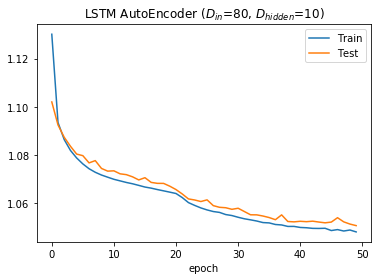

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM AutoEncoder ($D_{in}$=80, $D_{hidden}$=10)')
plt.legend(['Train', 'Test'], loc='upper right')
plt.xlabel('epoch')
plt.show()

### Model Evaluation

In [35]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state

In [36]:
# Load training data and obtrain the scaler fit
f_train=h5py.File('AE_train_qcd_preprocessed.h5','r')
x_train=f_train['table']
scaler=RobustScaler().fit(x_train[:10000, :80])
f_train.close()

In [37]:
# Load preprocessed test data

f_test_0=h5py.File('AE_test_qcd_preprocessed.h5','r')
f_test_1=h5py.File('AE_test_top_preprocessed.h5','r')
x_test_0=f_test_0['table']
x_test_1=f_test_1['table']

x_test=np.concatenate((x_test_0, x_test_1), axis=0)
y_test=np.concatenate((np.zeros(len(x_test_0)), np.ones(len(x_test_1))), axis=0)

rng = check_random_state(1)
indices = rng.permutation(len(x_test))

x_test_mix = [x_test[j] for j in indices[:100000]]
y_test_mix = [y_test[j] for j in indices[:100000]]
f_test_0.close()
f_test_1.close()

In [38]:
x_test_mix=np.array(x_test_mix)
y_test_mix=np.array(y_test_mix)

In [39]:
x_test_mix=scaler.transform(x_test_mix[:,:LEN_INPUT])
#x_test_mix=normalize(x_test_mix,axis=1)
x_test_mix=np.reshape(x_test_mix, (len(x_test_mix), -1, 4))

In [40]:
# load model
sequence_autoencoder=load_model('AE-LSTM-model-d80.h5')

In [41]:
predict_jets=sequence_autoencoder.predict(x_test_mix)
predict_loss_mse= np.mean(np.reshape(np.power(x_test_mix - predict_jets, 2),(len(x_test_mix), -1)), axis=1)

In [42]:
a=predict_loss_mse

(array([8.2150e+04, 1.0796e+04, 4.4350e+03, 1.8030e+03, 5.9600e+02,
        1.7300e+02, 4.0000e+01, 4.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-0.74875547,  0.49637718,  1.74150983,  2.98664248,  4.23177513,
         5.47690778,  6.72204043,  7.96717308,  9.21230572, 10.45743837,
        11.70257102]),
 <a list of 10 Patch objects>)

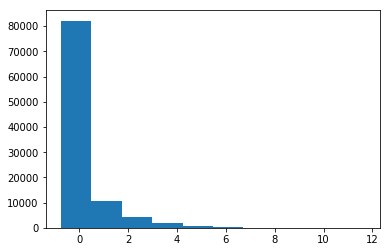

In [43]:
# this block is not mandatory
a=np.reshape(a, (-1,1))
tfa=StandardScaler().fit(a)
a=tfa.transform(a)

plt.hist(a)

/home/sxg3847/env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.


('roc_auc =', 0.4969699393255247)


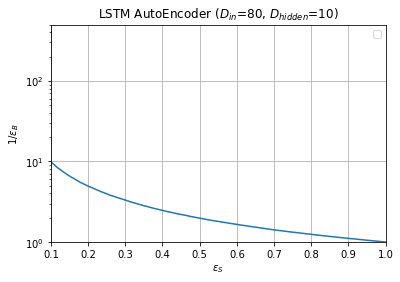

In [44]:
fpr, tpr, thrs = roc_curve(y_test_mix, a)
print("roc_auc =", roc_auc_score(y_test_mix, a))
#plt.plot(fpr, tpr, label="%s" % filename)
plt.plot(tpr, 1. / fpr, label="")

plt.xlim(0.1, 1.0)
plt.ylim(1, 500)
plt.yscale("log")
plt.grid()
plt.title('LSTM AutoEncoder ($D_{in}$=80, $D_{hidden}$=10)')
plt.xlabel("$\epsilon_S$")
plt.ylabel("$1/\epsilon_B$")
plt.legend(loc="best")
plt.show()